In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import *
import cv2
import numpy as np
import random
import os
import pandas as pd
import warnings
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Concatenate, Activation, Multiply, Reshape,
    GlobalAveragePooling2D, Dense, AveragePooling2D, Lambda, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers


C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
import tensorflow as tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\train",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\val",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\test",
    target_size=(224, 224),
    batch_size=16,
    shuffle=False  
)

print("Train classes:", train_generator.class_indices)
print("Validation classes:", val_generator.class_indices)
print("Test classes:", test_generator.class_indices)


Found 6660 images belonging to 4 classes.
Found 1918 images belonging to 4 classes.
Found 1293 images belonging to 4 classes.
Train classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Validation classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Test classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}


In [ ]:
def input_block(x):
    x = Conv2D(32, 3, strides=2, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(16, 3, strides=2, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(64, 1, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x
def residual_block(x, C):
    shortcut = x

    x = Conv2D(C, 1, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(C//4, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(C, 1, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x
def se_block(x, C):
    se = GlobalAveragePooling2D()(x)
    se = Reshape((1,1,C))(se)

    se = Conv2D(C//4, 1, activation="relu")(se)
    se = Conv2D(C, 1, activation="sigmoid")(se)

    return Multiply()([x, se])
def decomposition_block(x, C):
    x = MaxPooling2D(3, strides=2, padding="same")(x)
    x = Conv2D(2*C, 1, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
def TurkerNet(num_classes):
    inputs = Input((224,224,3))

    x = input_block(inputs)  

    x = residual_block(x, 64)
    x = se_block(x, 64)
    x = decomposition_block(x, 64)  

    x = residual_block(x, 128)
    x = se_block(x, 128)
    x = decomposition_block(x, 128) 

    x = residual_block(x, 256)
    x = se_block(x, 256)
    x = decomposition_block(x, 256) 

    x = residual_block(x, 512)
    x = se_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation="softmax")(x)

    return Model(inputs, x)
model = TurkerNet(num_classes=4)

model.compile(
    optimizer = Adam(1e-4),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [4]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.5,
    patience=8,
    verbose=1,
    cooldown=1,
    min_delta=0.0001
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=30,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

check_path = "TurkerNet_prostate_best.h5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    check_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max'
)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=65,
    callbacks=[reduce_lr, early_stop, checkpoint]
)


Epoch 1/65
417/417 [==============================] - 154s 358ms/step - loss: 0.8325 - accuracy: 0.6447 - val_loss: 1.3369 - val_accuracy: 0.4984

Epoch 00001: val_accuracy improved from -inf to 0.49844, saving model to TurkerNet_prostate_best.h5
Epoch 2/65
417/417 [==============================] - 65s 155ms/step - loss: 0.6676 - accuracy: 0.7113 - val_loss: 0.6372 - val_accuracy: 0.7185

Epoch 00002: val_accuracy improved from 0.49844 to 0.71846, saving model to TurkerNet_prostate_best.h5
Epoch 3/65
417/417 [==============================] - 64s 152ms/step - loss: 0.6086 - accuracy: 0.7281 - val_loss: 0.7732 - val_accuracy: 0.6715

Epoch 00003: val_accuracy did not improve from 0.71846
Epoch 4/65
417/417 [==============================] - 63s 152ms/step - loss: 0.5784 - accuracy: 0.7527 - val_loss: 0.9364 - val_accuracy: 0.5949

Epoch 00004: val_accuracy did not improve from 0.71846
Epoch 5/65
417/417 [==============================] - 63s 152ms/step - loss: 0.5421 - accuracy: 0.7590

In [9]:
model.load_weights("TurkerNet_prostate_best.h5")
np.save("TurkerNet_history.npy", history.history)
a = np.load("TurkerNet_history.npy", allow_pickle=True).item()


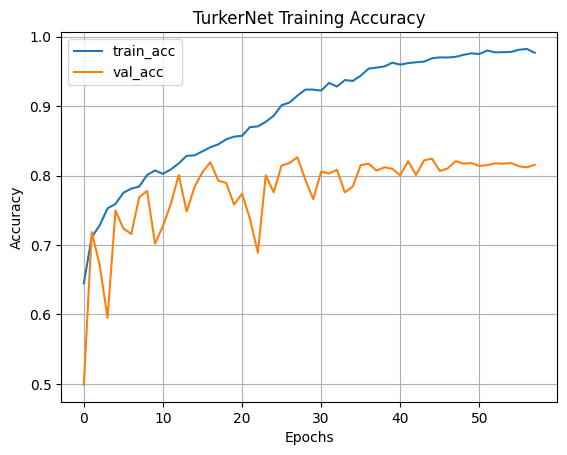

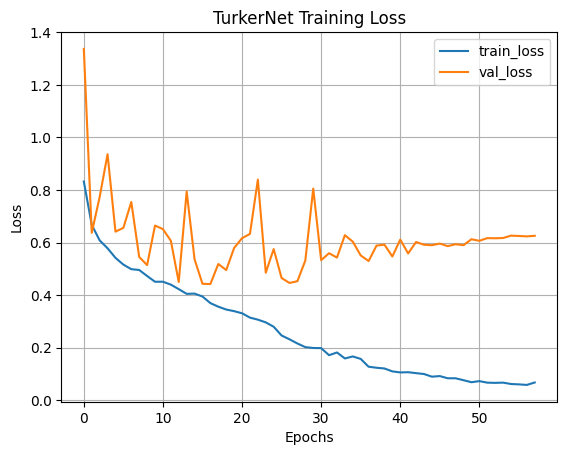

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(a['accuracy'], label='train_acc')
plt.plot(a['val_accuracy'], label='val_acc')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("TurkerNet Training Accuracy")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(a['loss'], label='train_loss')
plt.plot(a['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("TurkerNet Training Loss")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

test_generator.reset()
Y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
pred_class_indices = np.argmax(Y_pred, axis=1)

y_true = test_generator.labels

print("Predicted classes:", pred_class_indices)


81/81 [==============================] - 10s 125ms/step
Predicted classes: [0 0 0 ... 3 3 3]


In [8]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score

classes = [0,1,2,3]

for cl in classes:
    print("Class:", cl)

    a1 = np.uint8(y_true == cl)
    a2 = np.uint8(pred_class_indices == cl)

    print('Accuracy {}'.format(accuracy_score(a1, a2)))
    print('F1 {}'.format(f1_score(a1, a2)))
    print('Precision {}'.format(precision_score(a1, a2)))
    print('Recall {}'.format(recall_score(a1, a2)))
    print('Jaccard {}'.format(jaccard_score(a1, a2)))
    print("_______________________________")
from sklearn.metrics import confusion_matrix, classification_report

print('Accuracy {}'.format(accuracy_score(y_true, pred_class_indices)))
print('F1 {}'.format(f1_score(y_true, pred_class_indices, average="macro")))
print('Precision {}'.format(precision_score(y_true, pred_class_indices, average="macro")))
print('Recall {}'.format(recall_score(y_true, pred_class_indices, average="macro")))
print('Jaccard {}'.format(jaccard_score(y_true, pred_class_indices, average="macro")))

print('Confusion Matrix:\n', confusion_matrix(y_true, pred_class_indices))
print('Classification Report:\n', classification_report(y_true, pred_class_indices))


Class: 0
Accuracy 0.9690641918020109
F1 0.9555555555555556
Precision 0.9907834101382489
Recall 0.9227467811158798
Jaccard 0.9148936170212766
_______________________________
Class: 1
Accuracy 0.9048723897911833
F1 0.7366167023554604
Precision 0.7350427350427351
Recall 0.7381974248927039
Jaccard 0.5830508474576271
_______________________________
Class: 2
Accuracy 0.8669760247486465
F1 0.7902439024390244
Precision 0.7921760391198044
Recall 0.7883211678832117
Jaccard 0.6532258064516129
_______________________________
Class: 3
Accuracy 0.9311678267594741
F1 0.7769423558897243
Precision 0.7175925925925926
Recall 0.8469945355191257
Jaccard 0.6352459016393442
_______________________________
Accuracy 0.8360402165506574
F1 0.8148396290599412
Precision 0.8088986942233453
Recall 0.8240649773527302
Jaccard 0.6966040431424653
Confusion Matrix:
 [[430   3   1  32]
 [  2 172  58   1]
 [  1  58 324  28]
 [  1   1  26 155]]
Classification Report:
               precision    recall  f1-score   support

 